# Sangkak AI Challenge: NER tasks

--------------------------------------------------------------------------

- **Author**: Elvis MBONING (NTeALan Research and Development Team)
- **Session**: février 2023

--------------------------------------------------------------------------

In this notebook, we try to implement new methods which can potentialy improved NER task in low african resource languages.

We propose a rule-based approach call **Position to position entity augmentation** to normalize and augment lowest training data for CRF model. Our work is based on this paper (Xiang Dai and Heike Adel, 2020)[https://aclanthology.org/2020.coling-main.343.pdf].

# Experiments

In this experiment, we want to build ML model based on Conditional Random Field (CRF). 

## 1- Data processing and analysis

### 1.1. Loading data from Masakhane folder


In [ ]:
# Install python packages dependencies
!pip3 install pandas python_crfsuite summarytools sklearn_crfsuite
!pip3 install iteration_utilities matplotlib

In [ ]:
# Download Masakhane dataset from Github
!git clone https://github.com/masakhane-io/masakhane-ner.git

In [1]:
from pathlib import Path
import pandas as pd
import joblib
from datetime import datetime

from auglib import read_format_iob_data

In [2]:
# Reading folder path
# Context Masahkane community
# Ramshaw and Marcus (1995) = IOB data format
language = 'multi-all'
ner_path = Path(f'../data_source/masakhane-ner/MasakhaNER2.0/data/')
train_files = list(ner_path.glob("*/train.txt"))
dev_files = list(ner_path.glob("*/dev.txt"))

print(train_files)

[PosixPath('../data_source/masakhane-ner/MasakhaNER2.0/data/bbj/train.txt'), PosixPath('../data_source/masakhane-ner/MasakhaNER2.0/data/twi/train.txt'), PosixPath('../data_source/masakhane-ner/MasakhaNER2.0/data/mos/train.txt'), PosixPath('../data_source/masakhane-ner/MasakhaNER2.0/data/zul/train.txt'), PosixPath('../data_source/masakhane-ner/MasakhaNER2.0/data/swa/train.txt'), PosixPath('../data_source/masakhane-ner/MasakhaNER2.0/data/fon/train.txt'), PosixPath('../data_source/masakhane-ner/MasakhaNER2.0/data/ewe/train.txt'), PosixPath('../data_source/masakhane-ner/MasakhaNER2.0/data/xho/train.txt'), PosixPath('../data_source/masakhane-ner/MasakhaNER2.0/data/sna/train.txt'), PosixPath('../data_source/masakhane-ner/MasakhaNER2.0/data/kin/train.txt'), PosixPath('../data_source/masakhane-ner/MasakhaNER2.0/data/bam/train.txt'), PosixPath('../data_source/masakhane-ner/MasakhaNER2.0/data/wol/train.txt'), PosixPath('../data_source/masakhane-ner/MasakhaNER2.0/data/hau/train.txt'), PosixPath('

In [5]:
# read and extract iob data
extracted_train_data, pd_train_data, only_train_ner_data, o_train_ner_data = [],[],[],[]
extracted_dev_data, pd_dev_data, only_dev_ner_data, o_dev_ner_data = [],[],[],[]
total = 0
for tr, ts in zip(train_files, dev_files):
    extracted_train, pd_train, only_train_ner, o_train_ner = read_format_iob_data(tr)
    extracted_dev, pd_dev, only_dev_ner, o_dev_ner = read_format_iob_data(ts)
    extracted_train_data = extracted_train_data + extracted_train
    pd_train_data = pd_train if type(pd_train_data) == list else pd.concat([pd_train_data, pd_train], ignore_index=True)
    only_train_ner_data = only_train_ner_data + only_train_ner
    o_train_ner_data =  o_train_ner_data + o_train_ner
    extracted_dev_data = extracted_dev_data + extracted_dev
    pd_dev_data = pd_dev if type(pd_dev_data) == list else pd.concat([pd_dev_data, pd_dev], ignore_index=True)
    only_dev_ner_data = only_dev_ner_data + only_dev_ner
    o_dev_ner_data = o_dev_ner_data + o_dev_ner
    total += pd_train["sentence_id"].nunique()
    print(pd_train["sentence_id"].nunique())


# some stats 
print("Total number of sentences in the train dataset: {:,}".format(pd_train_data["sentence_id"].nunique()))
print("Total number of sentences in the train dataset: {:,}".format(total))
print("Total words in the train dataset: {:,}".format(pd_train_data.shape[0]))
print("Total number of sentences in the dev dataset: {:,}".format(pd_dev_data["sentence_id"].nunique()))
print("Total words in the dev dataset: {:,}".format(pd_dev_data.shape[0]))



3384
4240
4532
5848
6593
4343
3505
5718
6207
7825
4462
4593
5716
5646
3489
4942
6876
7634
Total number of sentences in the train dataset: 7,825
Total number of sentences in the train dataset: 95,553
Total words in the train dataset: 2,345,009
Total number of sentences in the dev dataset: 1,118
Total words in the dev dataset: 336,465


In [6]:
language = 'twi'
twi_ner_path = Path(f'../data_source/masakhane-ner/MasakhaNER2.0/data/twi')
bbj_ner_path = Path(f'../data_source/masakhane-ner/MasakhaNER2.0/data/bbj')
bam_ner_path = Path(f'../data_source/masakhane-ner/MasakhaNER2.0/data/bam')
ewe_ner_path = Path(f'../data_source/masakhane-ner/MasakhaNER2.0/data/ewe')
wol_ner_path = Path(f'../data_source/masakhane-ner/MasakhaNER2.0/data/wol')
zul_ner_path = Path(f'../data_source/masakhane-ner/MasakhaNER2.0/data/zul')
yor_ner_path = Path(f'../data_source/masakhane-ner/MasakhaNER2.0/data/yor')

bbj_test_data_path   = bbj_ner_path / 'train.txt'
twi_test_data_path   = twi_ner_path / 'train.txt'
bam_test_data_path   = bam_ner_path / 'train.txt'
ewe_test_data_path   = ewe_ner_path / 'train.txt'
wol_test_data_path   = wol_ner_path / 'train.txt'
zul_test_data_path   = zul_ner_path / 'train.txt'
yor_test_data_path   = yor_ner_path / 'train.txt'

# read and extract iob data
test_data = [bbj_test_data_path, twi_test_data_path, zul_test_data_path, yor_test_data_path, wol_test_data_path, 
             ewe_test_data_path, bam_test_data_path]
extracted_test_data, pd_test_data, only_test_ner_data, o_test_ner_data = [],[],[],[]
total = 0
for tr in test_data:
    extracted_test, pd_test, only_test_ner, o_test_ner = read_format_iob_data(tr)
    extracted_test_data = extracted_test_data + extracted_test
    pd_test_data = pd_test if type(pd_test_data) == list else pd.concat([pd_test_data, pd_test], ignore_index=True)
    for x in only_test_ner: only_test_ner_data.append(x)
    for x in o_test_ner: o_test_ner_data.append(x)
    total += len(only_test_ner)
    print(len(only_test_ner), len(pd_test.index), len(extracted_test))
    
print(total)


1771 50623 3384
2179 116400 4240
2660 95203 5848
4613 182711 6876
2492 127818 4593
2357 64162 3505
2048 111460 4462
18120


In [21]:
# saving augmented data
project = f"sangkak-{language}"
build_date = str(datetime.now()).replace(' ','_')

joblib.dump({
    "train": extracted_train_data, 
    "pd_train": pd_train_data
}, f'preprocessing/{project}_train_data_{build_date}.joblib')

['preprocessing/sangkak-multi-all_train_data_2023-03-13_20:20:45.964332.joblib']

### 1.3. Analyzing data 

In [22]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
# quantification des tags/phrases dans le corpus d'entrainement
# credit: https://github.com/6chaoran/jupyter-summarytools
from summarytools import dfSummary, tabset

tabset({
    "train_data": dfSummary(pd_train_data).render(),
    "dev_data": dfSummary(pd_dev_data).render()
})

# Un controle visuel des données et ce tableau montre clairement qu'il y a 
# des problématiques de cohérence d'annotations avec l'usage du format IOB.

In [ ]:
# representation of each entity tag
pd_train_data[pd_train_data.iob_tag != 'O']["iob_tag"]\
.value_counts().plot(kind="bar", figsize=(10,5))

# On remarque ici que le tag date représente 40% des tags (en position I ou B)

La phrase la plus longue contient 618 mots.
ID de la plus longue phrase 1404.

La phrase la plus longue du corpus est:
 Mnaoudǎ tí dəŋdzə tyə̌ʼ Mə́cwɔ̂ʼ tsʉʼ Sâʼ Bɔ̂kbɔ́k nwə̀ MBN . Korɔnobɔ a ɛkɔɔ so wɔ Dwoada , Oforisuo da a ɛtɔ so num wɔ afe mpem mmienu ne aduonu baako mu aberɛ a na abɔ anwummerɛ nnɔnson apa ho sima aduonu ( 7 : 20 pmɔ a mmarima baanan a na wɔkuta tuo ne sekan kɔbɔɔ korɔno wɔ Goodness Filling Station a ɛwɔ Akyem Osiem no , etuo kaa nipa baako . . Baa b sẽn waa n basa wã a Somé ra ket n yaɛɛsdame t'a zoe n kẽng kongo barzavil n yaool n tɩ sãa farãns 1988 ne 1994 . . Akusenani , leli phuzu lizokwengeza kokufunwa ukuzuzwa iqembu , lingcono iphuzu kunokwehlulwa , " kubeka uNcikazi . . Mapigano mengi yanasemekana kusababishwa na njaa ingawa pia yanasababisha hali hiyo . . Mɔ̌ ɖokpó ɔ """" Edwige Fifamɛ Aklu Tannyi nɔ kanbyɔ éɖee ɖɔ """" lè tɛ́ ká ɖémɛ nú nya ée è dó hwɛ bɛ ɖò gbawun ɔ jí din é """" bɛ ná hù mɛ lóbó ná lɛ́ sɔ anya mɛ kúkú ɔ tɔn dó xwé tɔn kpá . . 

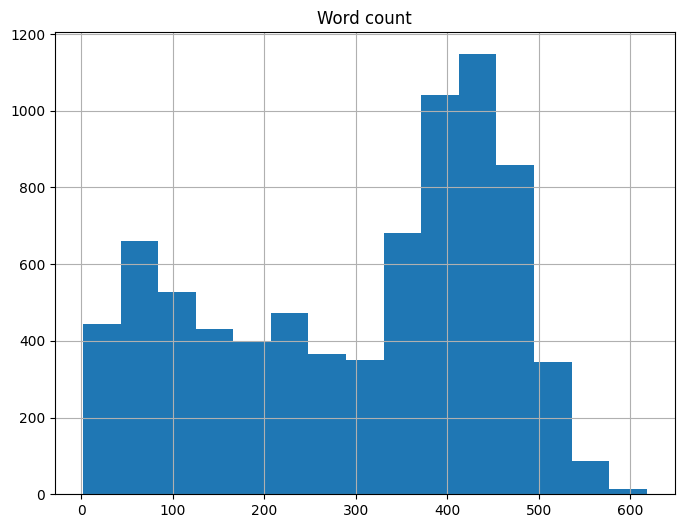

In [23]:

word_counts = pd_train_data.groupby("sentence_id")["word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=15, figsize=(8,6))

# On constate que le nombre de mots moyens par phrase est de 15
MAX_LENGTH_SENTENCE = word_counts.max()[0]
print("La phrase la plus longue contient {} mots.".format(MAX_LENGTH_SENTENCE))
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_LENGTH_SENTENCE].index[0]
print("ID de la plus longue phrase {}.".format(longest_sentence_id))
longest_sentence = pd_train_data[pd_train_data["sentence_id"]==longest_sentence_id]["word"].str.cat(sep=' ')
print(f"\nLa phrase la plus longue du corpus est:\n {longest_sentence}")


In [24]:
all_words = list(set(pd_train_data["word"].values))
all_tags = list(set(pd_train_data["iob_tag"].values))

print("Nombre de mots uniques: {}".format(pd_train_data["word"].nunique()))
print("Nombre de tags uniques : {}".format(pd_train_data["iob_tag"].nunique()))

Nombre de mots uniques: 250871
Nombre de tags uniques : 12


## 2- Features engineering

We will use differents kind of features to modelize our model. As ghomala is an african language, it is important to consider some of its features.

Any Bantu or semi-Bantu language use tone markers as morpho-syntatic properties to differentiate word or meaning. 

In [25]:
import unidecode
import re
from datetime import datetime
import string
import math
import unicodedata

### 2.1. Features based on african linguistics specificities

In [26]:
# importing features module 
from features import remove_accents, number_tone_word, extract_tone


In [27]:
# Constructing word features based on tones and API charaters
words_caracters = set([y.lower() for x in all_words for y in x])
all_caracters   = string.punctuation+string.ascii_letters+string.digits+''
tone_caracters  = list(set([x for x in words_caracters if x not in all_caracters]))
cpm_search      = re.compile(str(tone_caracters))

# Set of functions that normalizes and get features from datasets
bantou_tones = [f"{x} " for x in " ́̄̀̌̂" if x != " "]
string_tones = "".join(bantou_tones)
tones_search = re.compile(string_tones)

bantou_letters = string.ascii_letters+"ǝɔᵾɓɨşœɑʉɛɗŋøẅëïə"

non_tone = remove_accents("fə̀fə̀")

print(
    len("fə̀fə̀"), 
    len(non_tone), 
    number_tone_word("fə̀fə̀"), 
    "---"+extract_tone("fə̀fə̀")
)

print([x for x in "ntâmgǒ"])
print(tone_caracters, string_tones)

print(tone_caracters)

6 2 2 ---̀ ̀
['n', 't', 'â', 'm', 'g', 'ǒ']
['ķ', '茦', '²', 'ʊ', 'ɨ', '€', 'ƹ', 'ƴ', 'ć', 'ï', 'ì', '̣', 'ọ', '¬', 'ī', 'ẅ', '̂', 'ι', '👉', '̀', 'ɲ', 'ɗ', 'ǹ', '\xad', '᷅', '•', '》', '‘', 'ŭ', 'š', '£', 'ɒ', '᷆', 'ş', 'ç', 'ƞ', 'ṅ', 'ñ', 'ȼ', 'ļ', '鈥', 'ụ', 'ɩ', 'ǔ', 'ͻ', '™', '《', '̌', 'è', 'ղ', 'â', '�', 'ĕ', '̈', 'á', 'ʼ', 'í', 'ú', '\x9d', 'ó', 'ù', '̰', '͂', '茒', 'ǵ', 'ḿ', 'ə', 'ö', '\x8f', '̀', '©', 'ń', 'ź', 'ǐ', 'ϊ', 'ę', '蓳', 'ẽ', 'ü', '’', 'ě', 'ε', 'ë', '墨', 'ɓ', '×', 'à', 'û', 'ê', 'º', 'ā', '\u200f', '̩', 'ĭ', 'ä', 'ŋ', '蓷', 'ẉ', 'ʻ', 'ẁ', '鈧', 'ĺ', 'ǝ', '瞥', '̃', '苼', 'ɑ', 'ô', 'ꞌ', 'õ', '\u200b', '̄', 'ĩ', 'ø', '′', '«', 'ʉ', '奴', '¢', '¼', 'ɛ', '»', 'ǒ', 'ǎ', 'ɣ', 'ɔ', '茩', '°', 'ẃ', 'ś', 'ḱ', 'ã', 'ò', 'ɖ', 'ṵ', 'ũ', '̧', 'ƙ', 'æ', '¸', 'ẹ', 'ị', '拼', 'ʋ', '́', 'ƒ', '́', 'ṣ', 'œ', '膩', 'î', 'ᵾ', '½', 'é', 'ă', 'ŏ', '·'] ́ ̄ ̀ ̌ ̂ 
['ķ', '茦', '²', 'ʊ', 'ɨ', '€', 'ƹ', 'ƴ', 'ć', 'ï', 'ì', '̣', 'ọ', '¬', 'ī', 'ẅ', '̂', 'ι', '👉', '̀', 'ɲ', 'ɗ', 'ǹ', '\xad', '᷅', '•', '》', '

### 2.2. Features based on word and its contexts

In [28]:
# l'ajout des tags suivants au mot courant améliore signficativement le modèle
# l'ajout des informations sur les tons

from features import sent2features, sent2labels


### 2.3. Building all features and apply them to all datasets


In [29]:
# Build features from dataset 
print(len(extracted_train_data))

#train_sents = format_data(pd_train_data)
#dev_sents = format_data(pd_dev_data)
train_sents = [[word for word in sentence] for sentence in extracted_train_data]
dev_sents = [[word for word in sentence] for sentence in extracted_dev_data]

Xtrain = [sent2features(s) for s in train_sents]
ytrain = [sent2labels(s) for s in train_sents]

Xdev = [sent2features(s) for s in dev_sents]
ydev = [sent2labels(s) for s in dev_sents]


print(f"Train X aug lenght: {len(Xtrain)} | {len(ytrain)}")
print(f"Dev X aug lenght: {len(Xdev)} | {len(ydev)}")
Xtrain[2]

95553
Train X aug lenght: 95553 | 95553
Dev X aug lenght: 13652 | 13652


[{'bias': 1.0,
  'word': 'Cameroon',
  'word.tones': '',
  'word.normalized': 'Cameroon',
  'word.position': 0,
  'word.has_hyphen': False,
  'word.lower()': 'cameroon',
  'word.start_with_capital': True,
  'word.have_tone': False,
  'word.ispunctuation': False,
  'word.isdigit()': False,
  'BOS': True,
  '+1:word': 'Tribune',
  '+1:word.position': 1,
  '+1:word.letters': 'T r i b u n e',
  '+1:word.normalized': 'Tribune',
  '+1:word.start_with_capital': True,
  '+1:len(word2)': 7,
  '+1:word.lower()': 'tribune',
  '+1:word.isdigit()': False,
  '+1:word.ispunctuation': False},
 {'bias': 1.0,
  'word': 'Tribune',
  'word.tones': '',
  'word.normalized': 'Tribune',
  'word.position': 1,
  'word.has_hyphen': False,
  'word.lower()': 'tribune',
  'word.start_with_capital': True,
  'word.have_tone': False,
  'word.ispunctuation': False,
  'word.isdigit()': False,
  '-1:word': 'Cameroon',
  '-1:word.position': 0,
  '-1:word.letters': 'C a m e r o o n',
  '-1:word.normalized': 'Cameroon',
  '

In [30]:
project = f"sangkak-{language}"
build_date = str(datetime.now()).replace(' ','_')

joblib.dump({
    "Xtrain": Xtrain, "ytrain": ytrain, 
    "Xdev": Xdev, "ydev": ydev
}, f'preprocessing/{project}_featurised_train_dev_data_{build_date}.joblib') 

['preprocessing/sangkak-multi-all_featurised_train_dev_data_2023-03-13_20:21:43.467303.joblib']

In [2]:
data = joblib.load('preprocessing/{project}_featurised_train_dev_data_{build_date}.joblib')


In [31]:
Xtrain = data['Xtrain']
ytrain = data['ytrain']
Xdev = data['Xdev']
ydev = data['ydev']


NameError: name 'data' is not defined

# 3. Modelling with CRF algorithm

In [32]:
#import pycrfsuite
import sklearn_crfsuite
import math, string, re
import scipy
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn_crfsuite import metrics
from collections import Counter


### 3.1. Initialisation of pycrfsuite with training data

In [33]:
project = f"sangkak-{language}"
build_date = str(datetime.now()).replace(' ','_')
model_name = Path(f"models/multi/crf_{project}_{build_date}.model")
model_file = str(model_name)
file_crf = Path(f"models/multi/crf_{project}_{build_date}.object")

params = {
    "algorithm": 'lbfgs',
    "c1": 0.0920512484757745,
    "c2": 0.0328771171605105, 
    "max_iterations":100,
    "verbose":True,
    "num_memories":10000,
    "epsilon": 1e-3,
    "linesearch": "MoreThuente",
    "max_linesearch":100000,
    "delta":1e-4,
    #n_job=-1,
    #"c": 2,
    #"pa_type": 2,
    "all_possible_states":True,
    "all_possible_transitions":True, 
    "model_filename": model_file
}

crf = sklearn_crfsuite.CRF(**params)

crf.fit(Xtrain, ytrain, Xdev, ydev)    

final = {"crf": crf, "params": params}
joblib.dump(final, file_crf) 


loading training data to CRFsuite: 100%|██████████| 95553/95553 [01:02<00:00, 1533.30it/s]


loading dev data to CRFsuite: 100%|██████████| 13652/13652 [00:09<00:00, 1463.82it/s]



Holdout group: 2

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 1
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 31510680
Seconds required: 149.033

L-BFGS optimization
c1: 0.092051
c2: 0.032877
num_memories: 10000
max_iterations: 100
epsilon: 0.001000
stop: 10
delta: 0.000100
linesearch: MoreThuente
linesearch.max_iterations: 100000

Iter 1   time=17.53 loss=3466865.93 active=14562499 precision=0.074  recall=0.083  F1=0.079  Acc(item/seq)=0.891 0.348  feature_norm=0.50
Iter 2   time=6.83  loss=3219533.54 active=12433729 precision=0.074  recall=0.083  F1=0.079  Acc(item/seq)=0.891 0.348  feature_norm=0.46
Iter 3   time=7.52  loss=1974191.74 active=6550481 precision=0.074  recall=0.083  F1=0.079  Acc(item/seq)=0.891 0.348  feature_norm=0.74
Iter 4   time=11.84 loss=1937617.01 active=8909404 precision=0.074  recall=0.083  F1=0.079  Acc(item/seq)=0.891 0.348  feature_norm=0.75
Iter 5   time=5.61

# 4- Grid search

In other to optimised parameters of CRF model, we want here to find the best parameters that will fit to our data.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite import scorers
from itertools import chain
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
# get initial model parameters and delete c1 and c2 parameters
del params['c1']
del params['c2']

crf_grill = sklearn_crfsuite.CRF(**params)

labels = list(crf.classes_)
labels.remove('O')

params_space = {
    'c1': scipy.stats.expon(scale=0.1),
    'c2': scipy.stats.expon(scale=0.05)
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf_grill, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=5,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(Xtrain, ytrain)

In [ ]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [ ]:
#print(rs.cv_results_)
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_score_time']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [ ]:
crf_grid = rs.best_estimator_
y_pred = crf_grid.predict(Xtest)
print(metrics.flat_classification_report(
    ytest, y_pred, labels=sorted_labels, digits=3
))

In [ ]:

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

In [ ]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])